# Final Project 
- Author: Jennifer Gao
- Date Apr 6, 2025

Setup

In [1]:
import numpy as np
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
import os

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Create directories
data_dir = './molecular_data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

Molecule Generator Function

In [2]:
def generate_simple_molecular_graph(num_nodes=10):
    # Generate node features
    node_features = np.random.rand(num_nodes, 8)
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Create edges (first connect all nodes in a chain)
    edges = []
    for i in range(num_nodes-1):
        edges.append([i, i+1])
    
    # Add some random edges
    for _ in range(num_nodes // 3):
        start = np.random.randint(0, num_nodes)
        end = np.random.randint(0, num_nodes)
        if start != end and [start, end] not in edges and [end, start] not in edges:
            edges.append([start, end])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    
    # Generate edge features
    num_edges = edge_index.shape[1]
    edge_features = np.random.rand(num_edges, 3)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    # Generate target properties
    is_insecticide = np.random.randint(0, 2)
    log_p = np.random.normal(4.5, 1.5)
    y = torch.tensor([[is_insecticide, log_p]], dtype=torch.float)
    
    # Create Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    return data

Molecule Visualization Function

In [4]:
def visualize_molecule(data, save_path=None):
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add nodes and edges
    for i in range(data.x.shape[0]):
        G.add_node(i)
    
    edge_list = data.edge_index.t().numpy()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])
    
    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, 
            node_color=data.x[:, 0].numpy(), 
            with_labels=True, 
            node_size=500, 
            cmap=plt.cm.viridis,
            edge_color='gray',
            width=2.0,
            alpha=0.8)
    
    # Get molecule properties
    is_insecticide = data.y[0, 0].item()
    log_p = data.y[0, 1].item()
    
    plt.title(f"Example Molecule (Insecticide: {'Yes' if is_insecticide == 1 else 'No'}, LogP: {log_p:.2f})")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    


Generate a Sample Molecule

Sample molecule: 10 nodes, 12 edges


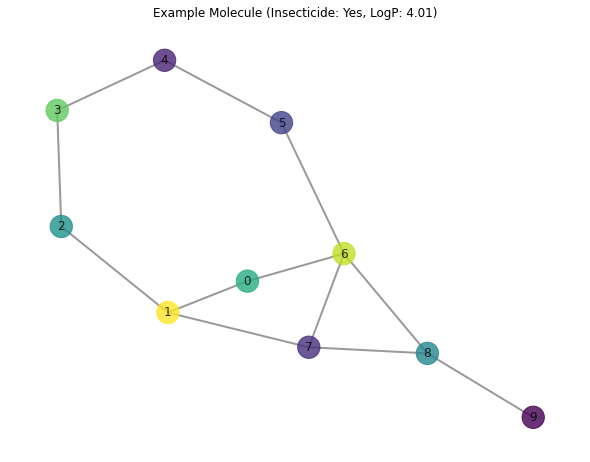

In [5]:
# Generate and visualize a sample molecule
sample = generate_simple_molecular_graph(10)
print(f"Sample molecule: {sample.num_nodes} nodes, {sample.num_edges} edges")
visualize_molecule(sample, "sample_molecule.png")

 Generate Dataset Function

In [6]:
def generate_dataset(num_samples, save_dir, prefix="molecule"):
    print(f"Generating {num_samples} molecules in {save_dir}...")
    
    for i in range(num_samples):
        # Randomly vary the number of nodes
        num_nodes = np.random.randint(5, 16)
        
        # Generate molecule
        data = generate_simple_molecular_graph(num_nodes)
        
        # Save to file
        file_path = os.path.join(save_dir, f'{prefix}_{i}.pt')
        torch.save(data, file_path)
    
    print(f"Generated {num_samples} molecules")

 Generate Training and Validation Datasets

In [7]:
# Generate small datasets for quick testing
generate_dataset(50, train_dir, "train_molecule")
generate_dataset(10, val_dir, "val_molecule")

Generating 50 molecules in ./molecular_data/train...
Generated 50 molecules
Generating 10 molecules in ./molecular_data/val...
Generated 10 molecules


Define Model Components

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class MoleculeEncoder(nn.Module):
    def __init__(self, node_features, hidden_dim=64, latent_dim=32):
        super(MoleculeEncoder, self).__init__()
        
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        x = global_mean_pool(x, batch)
        z = self.mlp(x)
        
        return z

class PropertyPredictor(nn.Module):
    def __init__(self, latent_dim, output_dim=2):
        super(PropertyPredictor, self).__init__()
        
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    
    def forward(self, z):
        return self.predictor(z)

Define Complete Model

In [9]:
class SimpleModel(nn.Module):
    def __init__(self, node_features, latent_dim=32):
        super(SimpleModel, self).__init__()
        self.encoder = MoleculeEncoder(node_features, latent_dim=latent_dim)
        self.property_predictor = PropertyPredictor(latent_dim)
    
    def forward(self, data):
        z = self.encoder(data)
        props = self.property_predictor(z)
        return z, props

Create Dataset and Loader

In [10]:
from torch_geometric.loader import DataLoader

# Custom dataset class
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.file_list = [f for f in os.listdir(directory) if f.endswith('.pt')]
        print(f"Loaded {len(self.file_list)} molecules from {directory}")
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.file_list[idx])
        return torch.load(file_path)

# Create dataset and loader
train_dataset = MoleculeDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Loaded 850 molecules from ./molecular_data/train


Initialize and Test Model

In [11]:
# Initialize model
model = SimpleModel(node_features=8)  # 8 node features in our generated data

# Test model with a batch
batch = next(iter(train_loader))
z, props = model(batch)
print(f"Batch size: {batch.num_graphs}")
print(f"Latent vectors shape: {z.shape}")
print(f"Predicted properties shape: {props.shape}")

Batch size: 8
Latent vectors shape: torch.Size([8, 32])
Predicted properties shape: torch.Size([8, 2])


Latent Space Visualization Function

In [12]:
from sklearn.decomposition import PCA

def visualize_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_vectors = []
    insecticide_labels = []
    logp_values = []
    
    # Collect latent representations
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            z, _ = model(batch)
            
            latent_vectors.append(z.cpu().numpy())
            insecticide_labels.append(batch.y[:, 0].cpu().numpy())
            logp_values.append(batch.y[:, 1].cpu().numpy())
    
    # Concatenate all batches
    latent_vectors = np.vstack(latent_vectors)
    insecticide_labels = np.concatenate(insecticide_labels)
    logp_values = np.concatenate(logp_values)
    
    print(f"Collected {len(latent_vectors)} latent vectors")
    
    # Apply PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                         c=insecticide_labels,
                         cmap='coolwarm',
                         s=100,
                         alpha=0.7)
    
    # Add LogP labels
    for i, (x, y, logp) in enumerate(zip(latent_2d[:, 0], latent_2d[:, 1], logp_values)):
        plt.text(x, y, f"{logp:.1f}", fontsize=9)
    
    plt.colorbar(scatter, label="Insecticide Activity")
    plt.title("Latent Space Visualization (PCA)")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.grid(alpha=0.3)
    
    plt.savefig("latent_space_viz.png", dpi=300, bbox_inches='tight')
    plt.show()

Collected 850 latent vectors


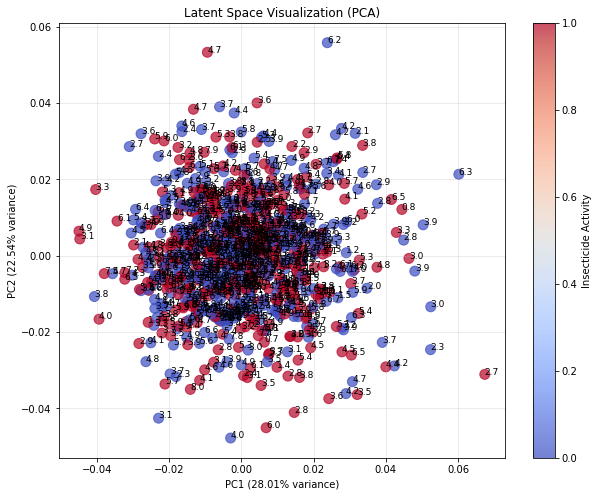

In [13]:
# Visualize latent space
visualize_latent_space(model, train_loader)